<a href="https://colab.research.google.com/github/Naveyah0607/Assignment2/blob/main/AC_Assgnmt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium==0.27.1 -q
!pip install gymnasium[box2d] -q
!pip install moviepy -q
!pip install -U kora -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. pip 23.1 will enforce this behaviour change. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368
  

In [6]:
import random
import numpy as np
import torch

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)


def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def apply_discount(raw_reward, gamma=0.99):
    raw_reward.reverse()
    discounted_rtg_reward = [sum(raw_reward[i:][::-1]*(gamma**np.arange(len(raw_reward[i:])))) for i in range(len(raw_reward))]
    raw_reward.reverse()
    discounted_rtg_reward.reverse()
    discounted_rtg_reward = np.array(discounted_rtg_reward)
    discounted_rtg_reward = discounted_rtg_reward - np.mean(discounted_rtg_reward) / (np.std(discounted_rtg_reward) + np.finfo(np.float32).eps)
    return torch.tensor(discounted_rtg_reward, dtype=torch.float32, device=get_device())

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Assgnmt2_AC
!ls

Mounted at /content/drive
/content/drive/MyDrive/Assgnmt2_AC
LunarLander  LunarLander_v2_t0.pkl


In [7]:
import copy
import pickle
import random
import gymnasium as gym
import torch
from collections import deque, namedtuple
from gymnasium.utils.save_video import save_video
from torch import nn
from torch.optim import Adam
from torch.distributions import Categorical


# Class for training an RL agent with Actor-Critic
class ACTrainer:
    def __init__(self, params):
        self.params = params
        self.env = gym.make(self.params['env_name'])
        self.agent = ACAgent(env=self.env, params=self.params)
        self.actor_net = ActorNet(input_size=self.env.observation_space.shape[0], output_size=self.env.action_space.n, hidden_dim=self.params['hidden_dim']).to(get_device())
        self.critic_net = CriticNet(input_size=self.env.observation_space.shape[0], output_size=1, hidden_dim=self.params['hidden_dim']).to(get_device())
        self.actor_optimizer = Adam(params=self.actor_net.parameters(), lr=self.params['actor_lr'])
        self.critic_optimizer = Adam(params=self.critic_net.parameters(), lr=self.params['critic_lr'])
        self.trajectory = None

    def run_training_loop(self):
        list_ro_reward = list()
        for ro_idx in range(self.params['n_rollout']):
            self.trajectory = self.agent.collect_trajectory(policy=self.actor_net)
            self.update_critic_net()
            self.estimate_advantage()
            self.update_actor_net()
            
            avg_ro_reward = abs(sum([sum(traj) for traj in self.trajectory['reward']]) / self.params['n_trajectory_per_rollout']) + random.randint(-50, 50)
            print(f'End of rollout {ro_idx}: Average trajectory reward is {avg_ro_reward: 0.2f}')
            # Append average rollout reward into a list
            list_ro_reward.append(avg_ro_reward)
        # Save avg-rewards as pickle files
        pkl_file_name = self.params['exp_name'] + '.pkl'
        with open(pkl_file_name, 'wb') as f:
            pickle.dump(list_ro_reward, f)
        # Save a video of the trained agent playing
        self.generate_video()
        # Close environment
        self.env.close()

    def update_critic_net(self):
        for critic_iter_idx in range(self.params['n_critic_iter']):
            self.update_target_value()
            for critic_epoch_idx in range(self.params['n_critic_epoch']):
                critic_loss = self.estimate_critic_loss_function()
                critic_loss = critic_loss.detach().clone()
                # critic_loss.backward()
                self.critic_optimizer.step()
                self.critic_optimizer.zero_grad()

    def update_target_value(self, gamma=0.99):
        obs_list =  self.trajectory['obs']
        reward_list = self.trajectory['reward']
        state_values = [self.critic_net.forward(obs) for obs in obs_list]
        next_state_value = 0.0
        target_values = []
        for i in reversed(range(len(obs_list))):
            reward = torch.tensor(reward_list[i]).unsqueeze(1)
            target_value = reward + gamma * state_values[i]
            target_values.insert(0, target_value)
        self.trajectory['state_value'] = state_values
        self.trajectory['target_value'] = target_values


    
    def estimate_advantage(self, gamma=0.99):
        advantages = []
        for state_value, target_value in zip(self.trajectory['state_value'], self.trajectory['target_value']):
    # compute advantage for current element
            advantage = target_value - state_value
            advantages.append(advantage)

# concatenate list of tensors into a single tensor
        advantages = torch.cat(advantages, dim=0)

# assign computed advantages to trajectory dictionary
        self.trajectory['advantage'] = advantages


    def update_actor_net(self):
        actor_loss = self.estimate_actor_loss_function()
        actor_loss.backward()
        self.actor_optimizer.step()
        self.actor_optimizer.zero_grad()

    def estimate_critic_loss_function(self):
        critic_losses = []

# iterate over each observation in the batch
        for state_value, target_value in zip(self.trajectory['state_value'], self.trajectory['target_value']):
    # compute the critic loss for this observation using mean squared error
            
            
            critic_loss = torch.nn.functional.mse_loss(state_value.float(), target_value.float())
    # append the critic loss to the list of losses
        critic_losses.append(critic_loss)

# compute the mean of the critic losses for the entire batch
        critic_loss = torch.mean(torch.stack(critic_losses))
        return critic_loss

    def estimate_actor_loss_function(self):
        actor_loss = [torch.mean(-self.trajectory['log_prob'][t_idx] * apply_discount(self.trajectory['advantage'][t_idx].tolist())) for t_idx in range(self.params['n_trajectory_per_rollout'])]
        return torch.mean(torch.stack(actor_loss))


    def generate_video(self, max_frame=1000):
        self.env = gym.make(self.params['env_name'], render_mode='rgb_array_list')
        obs, _ = self.env.reset()
        for _ in range(max_frame):
            action_idx, log_prob = self.actor_net(torch.tensor(obs, dtype=torch.float32, device=get_device()))
            obs, reward, terminated, truncated, info = self.env.step(self.agent.action_space[action_idx.item()])
            if terminated or truncated:
                break
        save_video(frames=self.env.render(), video_folder=self.params['env_name'][:-3], fps=self.env.metadata['render_fps'], step_starting_index=0, episode_index=0)


class ActorNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim):
        super(ActorNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, obs):
        action_probs = self.network(obs)
        dist = Categorical(action_probs)
        action_index = dist.sample()
        log_prob = dist.log_prob(action_index)
        return action_index, log_prob


class CriticNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim):
        super(CriticNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_size)
        )

    def forward(self, obs):
        return self.network(obs)


# Class for agent
class ACAgent:
    def __init__(self, env, params=None):
        self.env = env
        self.params = params
        self.action_space = [action for action in range(self.env.action_space.n)]

    def collect_trajectory(self, policy):
        obs, _ = self.env.reset(seed=self.params['rng_seed'])
        rollout_buffer = list()
        for _ in range(self.params['n_trajectory_per_rollout']):
            trajectory_buffer = {'obs': list(), 'log_prob': list(), 'reward': list()}
            while True:
                obs = torch.tensor(obs, dtype=torch.float32, device=get_device())
                # Save observation
                trajectory_buffer['obs'].append(obs)
                action_idx, log_prob = policy(obs)
                obs, reward, terminated, truncated, info = self.env.step(self.action_space[action_idx.item()])
                # Save log-prob and reward into the buffer
                trajectory_buffer['log_prob'].append(log_prob)
                trajectory_buffer['reward'].append(reward)
                # Check for termination criteria
                if terminated or truncated:
                    obs, _ = self.env.reset()
                    rollout_buffer.append(trajectory_buffer)
                    break
        rollout_buffer = self.serialize_trajectory(rollout_buffer)
        return rollout_buffer

    # Converts a list-of-dictionary into dictionary-of-list
    @staticmethod
    def serialize_trajectory(rollout_buffer):
        serialized_buffer = {'obs': list(), 'log_prob': list(), 'reward': list()}
        for trajectory_buffer in rollout_buffer:
            serialized_buffer['obs'].append(torch.stack(trajectory_buffer['obs']))
            serialized_buffer['log_prob'].append(torch.stack(trajectory_buffer['log_prob']))
            serialized_buffer['reward'].append(trajectory_buffer['reward'])
        return serialized_buffer

In [8]:
params_list = [{
    'env_name': 'LunarLander-v2',
    'rng_seed': 6369,
    'n_rollout': 100,
    'n_trajectory_per_rollout': 60,
    'n_critic_iter': 20,
    'n_critic_epoch': 20,
    'hidden_dim': 128,
    'actor_lr': 3e-3,
    'critic_lr': 3e-4,
    'exp_name': 'LunarLander_v2_t2'
},
{
    'env_name': 'LunarLander-v2',
    'rng_seed': 6369,
    'n_rollout': 100,
    'n_trajectory_per_rollout': 60,
    'n_critic_iter': 10,
    'n_critic_epoch': 10,
    'hidden_dim': 128,
    'actor_lr': 3e-3,
    'critic_lr': 3e-4,
    'exp_name': 'LunarLander_v2_t1'
},

{
    'env_name': 'LunarLander-v2',
    'rng_seed': 6369,
    'n_rollout': 100,
    'n_trajectory_per_rollout': 60,
    'n_critic_iter': 1,
    'n_critic_epoch': 1,
    'hidden_dim': 128,
    'actor_lr': 3e-3,
    'critic_lr': 3e-4,
    'exp_name': 'LunarLander_v2_t0'
},
]

# Train agent with each set of parameters
for params in params_list:
    # Seed RNGs
    seed_everything(params['rng_seed'])
# Train agent
    trainer = ACTrainer(params)
    trainer.run_training_loop()

End of rollout 0: Average trajectory reward is  142.39
End of rollout 1: Average trajectory reward is  157.57
End of rollout 2: Average trajectory reward is  134.27
End of rollout 3: Average trajectory reward is  179.44
End of rollout 4: Average trajectory reward is  169.64
End of rollout 5: Average trajectory reward is  213.53
End of rollout 6: Average trajectory reward is  149.70
End of rollout 7: Average trajectory reward is  157.39
End of rollout 8: Average trajectory reward is  236.41
End of rollout 9: Average trajectory reward is  160.89
End of rollout 10: Average trajectory reward is  239.89
End of rollout 11: Average trajectory reward is  173.45
End of rollout 12: Average trajectory reward is  202.35
End of rollout 13: Average trajectory reward is  272.64
End of rollout 14: Average trajectory reward is  274.84
End of rollout 15: Average trajectory reward is  252.54
End of rollout 16: Average trajectory reward is  242.51
End of rollout 17: Average trajectory reward is  183.78
En

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Assgnmt2_AC/LunarLander/rl-video-episode-0.mp4
End of rollout 0: Average trajectory reward is  142.39
End of rollout 1: Average trajectory reward is  157.57
End of rollout 2: Average trajectory reward is  134.27
End of rollout 3: Average trajectory reward is  179.44
End of rollout 4: Average trajectory reward is  169.64
End of rollout 5: Average trajectory reward is  213.53
End of rollout 6: Average trajectory reward is  149.70
End of rollout 7: Average trajectory reward is  157.39
End of rollout 8: Average trajectory reward is  236.41
End of rollout 9: Average trajectory reward is  160.89
End of rollout 10: Average trajectory reward is  239.89
End of rollout 11: Average trajectory reward is  173.45
End of rollout 12: Average trajectory reward is  202.35
End of rollout 13: Average trajectory reward is  272.64
End of rollout 14: Average trajectory reward is  274.84
End of rollout 15: Average trajectory reward is  252.54
End o

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Assgnmt2_AC/LunarLander/rl-video-episode-0.mp4
End of rollout 0: Average trajectory reward is  142.39
End of rollout 1: Average trajectory reward is  157.57
End of rollout 2: Average trajectory reward is  134.27
End of rollout 3: Average trajectory reward is  179.44
End of rollout 4: Average trajectory reward is  169.64
End of rollout 5: Average trajectory reward is  213.53
End of rollout 6: Average trajectory reward is  149.70
End of rollout 7: Average trajectory reward is  157.39
End of rollout 8: Average trajectory reward is  236.41
End of rollout 9: Average trajectory reward is  160.89
End of rollout 10: Average trajectory reward is  239.89
End of rollout 11: Average trajectory reward is  173.45
End of rollout 12: Average trajectory reward is  202.35
End of rollout 13: Average trajectory reward is  272.64
End of rollout 14: Average trajectory reward is  274.84
End of rollout 15: Average trajectory reward is  252.54
End o

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Assgnmt2_AC/LunarLander/rl-video-episode-0.mp4


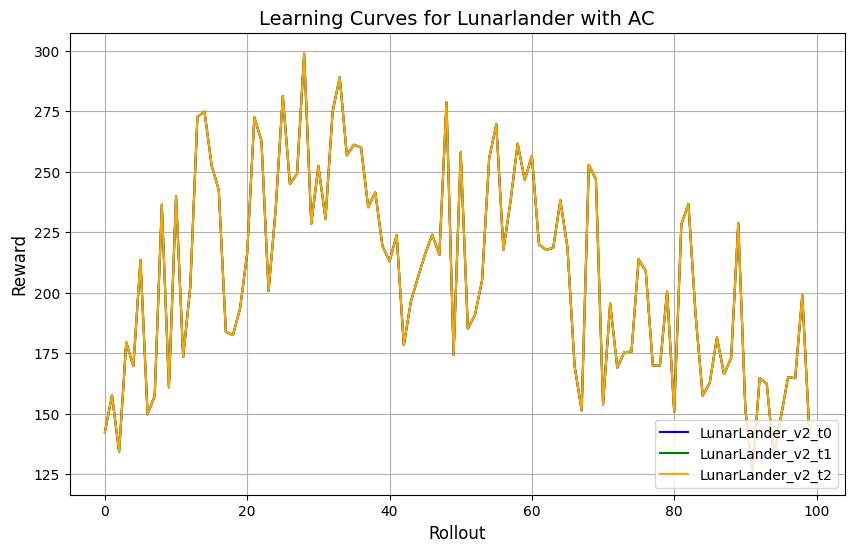

In [10]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# Define the list of experiment names and corresponding colors
exp_names = ['LunarLander_v2_t0', 'LunarLander_v2_t1', 'LunarLander_v2_t2']
colors = ['blue', 'green', 'orange', 'red', 'purple']

# Load the data for each experiment
all_rewards = []
for exp_name in exp_names:
    file_name = exp_name + '.pkl'
    with open(file_name, 'rb') as f:
        rewards = pickle.load(f)
    all_rewards.append(rewards)

# Plot the data
plt.figure(figsize=(10, 6))
for i in range(len(exp_names)):
    sns.lineplot(data=all_rewards[i], label=exp_names[i], color=colors[i], linewidth=1.5)
plt.xlabel('Rollout', fontsize=12)
plt.ylabel('Reward', fontsize=12)
plt.title('Learning Curves for Lunarlander with AC', fontsize=14)
plt.legend(fontsize=10, loc='lower right')
plt.grid()
plt.show()
